In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Load dataset
df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/red_wine_quality.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


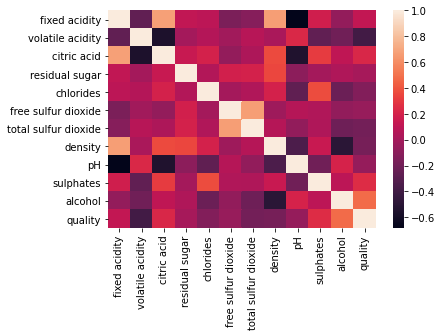

In [8]:
import seaborn as sns
sns.heatmap(df.corr())

In [12]:
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [10]:
input_size=11
output_size=1
inputs= df.drop('quality',1).values
targets= df[['quality']].values
inputs.shape, targets.shape

((1599, 11), (1599, 1))

In [43]:
# convert to pytorch dataset
dataset= TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds= random_split(dataset, [1199,400])

batch_size=32
train_loader= DataLoader(train_ds, batch_size, shuffle=True)
val_loader= DataLoader(val_ds, batch_size)

In [23]:
for batch in val_loader:
  print(batch)
  break

[tensor([[1.0100e+01, 3.1000e-01, 4.4000e-01, 2.3000e+00, 8.0000e-02, 2.2000e+01,
         4.6000e+01, 9.9880e-01, 3.3200e+00, 6.7000e-01, 9.7000e+00],
        [8.5000e+00, 3.2000e-01, 4.2000e-01, 2.3000e+00, 7.5000e-02, 1.2000e+01,
         1.9000e+01, 9.9434e-01, 3.1400e+00, 7.1000e-01, 1.1800e+01],
        [7.2000e+00, 3.8000e-01, 3.0000e-01, 1.8000e+00, 7.3000e-02, 3.1000e+01,
         7.0000e+01, 9.9685e-01, 3.4200e+00, 5.9000e-01, 9.5000e+00],
        [9.6000e+00, 6.8000e-01, 2.4000e-01, 2.2000e+00, 8.7000e-02, 5.0000e+00,
         2.8000e+01, 9.9880e-01, 3.1400e+00, 6.0000e-01, 1.0200e+01],
        [7.9000e+00, 7.6500e-01, 0.0000e+00, 2.0000e+00, 8.4000e-02, 9.0000e+00,
         2.2000e+01, 9.9619e-01, 3.3300e+00, 6.8000e-01, 1.0900e+01],
        [6.8000e+00, 6.5000e-01, 2.0000e-02, 2.1000e+00, 7.8000e-02, 8.0000e+00,
         1.5000e+01, 9.9498e-01, 3.3500e+00, 6.2000e-01, 1.0400e+01],
        [8.7000e+00, 5.2000e-01, 9.0000e-02, 2.5000e+00, 9.1000e-02, 2.0000e+01,
         4.9

## Model

In [44]:
class WineModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear= nn.Linear(input_size,output_size)

  def forward(self, xb):
    out= self.linear(xb)
    return out

  def training_step(self, batch):
    inputs, targets= batch
    out= self(inputs)
    loss= F.l1_loss(out, targets)
    return loss

  def validation_step(self, batch):
    inputs, targets= batch
    out= self(inputs)
    loss= F.l1_loss(out, targets)
    return {'val_loss': loss.detach()}

  def validation_epoch_end(self, outputs):
    batch_losses= [x['val_loss'] for x in outputs]
    epoch_loss= torch.stack(batch_losses).mean()
    return {'val_loss': epoch_loss.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))

model= WineModel()

## Training

In [45]:
def evaluate(model, val_loader):
  outputs= [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr,model, train_loader, val_loader, opt_func= torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
      # Training Phase 
      for batch in train_loader:
          loss = model.training_step(batch)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
      # Validation phase
      result = evaluate(model, val_loader)
      model.epoch_end(epoch, result)
      history.append(result)
  return history

In [46]:
# loss before training
result= evaluate(model, val_loader)
result

{'val_loss': 6.7763566970825195}

In [47]:
history = fit(4, 1e-2, model, train_loader, val_loader)

Epoch [0], val_loss: 4.1831
Epoch [1], val_loss: 19.8511
Epoch [2], val_loss: 9.8295
Epoch [3], val_loss: 7.4437


In [48]:
history2 = fit(4, 1e-3, model, train_loader, val_loader)

Epoch [0], val_loss: 0.9676
Epoch [1], val_loss: 1.9971
Epoch [2], val_loss: 0.7665
Epoch [3], val_loss: 1.2364


In [49]:
history3 = fit(4, 1e-4, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6199
Epoch [1], val_loss: 0.6175
Epoch [2], val_loss: 0.6166
Epoch [3], val_loss: 0.6109


In [50]:
history4 = fit(4, 1e-5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6110
Epoch [1], val_loss: 0.6109
Epoch [2], val_loss: 0.6108
Epoch [3], val_loss: 0.6102


In [52]:
history4

[{'val_loss': 0.6109574437141418},
 {'val_loss': 0.6109207272529602},
 {'val_loss': 0.6107542514801025},
 {'val_loss': 0.6101979613304138}]

In [53]:
result # loss before training

{'val_loss': 6.7763566970825195}

Text(0.5, 1.0, 'val_loss vs. epochs')

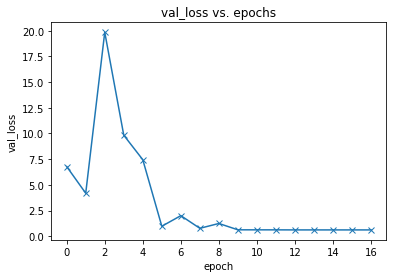

In [56]:
losses = [r['val_loss'] for r in [result] + history+ history2+ history3+ history4]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs')

## Prediction

In [57]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [58]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([ 6.9000,  0.5400,  0.0400,  3.0000,  0.0770,  7.0000, 27.0000,  0.9987,
         3.6900,  0.9100,  9.4000])
Target:  6.0
Prediction: 4.7110185623168945


In [59]:
x.unsqueeze(0)

tensor([[ 6.9000,  0.5400,  0.0400,  3.0000,  0.0770,  7.0000, 27.0000,  0.9987,
          3.6900,  0.9100,  9.4000]])

In [60]:
x, target = val_ds[20]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([ 6.0000,  0.5000,  0.0000,  1.4000,  0.0570, 15.0000, 26.0000,  0.9945,
         3.3600,  0.4500,  9.5000])
Target:  5.0
Prediction: 4.693277359008789
